# Programming Assignment 1:  Data Preparation and Understanding

1. http://vision.stanford.edu/aditya86/ImageNetDogs/
2. https://scikit-image.org/

##### a) CroppingandResizeImagesinYour4-classImagesDataset: 
https://www.kaggle.com/code/espriella/stanford-dogs-transfer-crop-stack/notebook

In [1]:
import os,cv2
dir = os.getcwd()
images_folder = 'Images/'
os.listdir(os.path.join(dir,images_folder))

['Great_Dane', 'papillon', 'Pomeranian', 'Rhodesian_ridgeback']

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import required libraries 

import os,cv2
import xml.etree.ElementTree as ET

dir = os.getcwd()
images_folder = 'Images/'
annotations_folder = 'Annotations/'
out_folder = "Cropped_Images"
os.makedirs(out_folder, exist_ok=True)
def is_xml_file(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            return '<annotation>' in content
    except Exception as e:
        return False

# Loop through each specific folder
for folder in os.listdir(os.path.join(dir,images_folder)) :
    img_folder = os.path.join(images_folder, folder)
    annot_folder = os.path.join(annotations_folder, folder)
    for filename in os.listdir(annot_folder):
        file_path = os.path.join(annot_folder, filename)
        if is_xml_file(file_path):
            tree = ET.parse(file_path)
            root = tree.getroot()
            image_filename = root.find('filename').text
            image_path = os.path.join(dir, img_folder, image_filename)
            image = cv2.imread(image_path+".jpg")                
            if image is not None:
                for obj in root.findall('object'):
                    bbox = obj.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)
                    roi = image[ymin:ymax, xmin:xmax]
                    resized_roi = cv2.resize(roi,(128,128))
                    out_folder_path = os.path.join(out_folder, folder)
                    os.makedirs(out_folder_path, exist_ok=True)
                    out_path = os.path.join(out_folder_path, f'{image_filename}.jpg')
                    cv2.imwrite(out_path,resized_roi)
print("-----------Cropping and ResizeImages completed----------")

-----------Cropping and ResizeImages completed----------


##### (b) Feature Extraction: Edge histogram AND Similarity Measurements

i)Choose 1 image from each class.

In [6]:
images=['Images/papillon/n02086910_10147.jpg','Images/Great_Dane/n02109047_1005.jpg','Images/Pomeranian/n02112018_10129.jpg','Images/Rhodesian_ridgeback/n02087394_10014.jpg']

ii. Convert the color images to grayscale images 
https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html

In [8]:
from skimage import io, color, filters, exposure
from skimage.color import rgb2gray
def convert_gray(image):
    img = io.imread(image)
    gray_img = color.rgb2gray(img)
    return gray_img

 iii. For each image 𝐼, use the following
 import numpy as np
 from skimage import filters
 def angle(dx, dy):
 """Calculate the angles between horizontal and vertical operators."""
 return np.mod(np.arctan2(dy, dx), np.pi)
 angle_sobel = angle(filters.sobel_h(I),
 filters.sobel_v(I))
 to obtain an “angle” for each pixel in the images (Intuitively, one can think of the “angle” as
 the direction of edge gradient at the pixel).

In [10]:
import numpy as np
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)
#angle_sobel = angle(filters.sobel_h(I),filters.sobel_v(I))

 iv. Useskimage.exposure.histogram(seehttps://scikit-image.org/docs/stable/api/
 skimage.exposure.html#skimage.exposure.histogram)toobtainahistogramwith36
 bins.

 Plot the images with their corresponding edge histogram values (add x-axis label “Bins” and
 y-axis label “Pixel Count” ).

Images/papillon/n02086910_10147.jpg


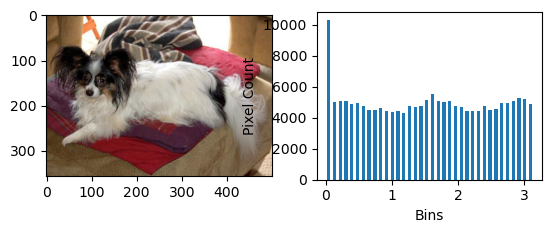

Images/Great_Dane/n02109047_1005.jpg


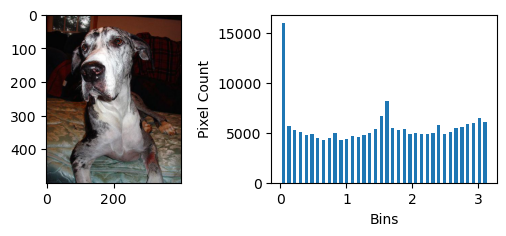

Images/Pomeranian/n02112018_10129.jpg


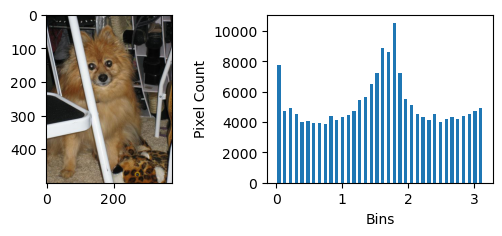

Images/Rhodesian_ridgeback/n02087394_10014.jpg


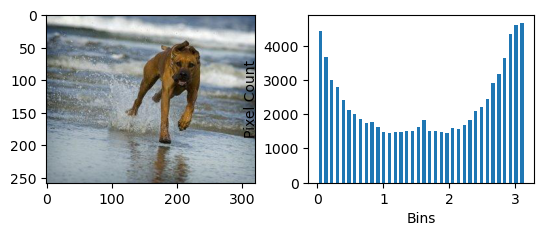

In [13]:
import matplotlib.pyplot as plt
edge_histograms=[]
for img in images:
    gray_image = convert_gray(img) 
    angle_sobel = angle(filters.sobel_h(gray_image), filters.sobel_v(gray_image))
    hist,hist_centers =exposure.histogram(angle_sobel,nbins=36)
    edge_histograms.append(hist)
    print(img)
    plt.subplot(221),plt.imshow(io.imread(img))
    plt.subplot(222),plt.bar(hist_centers, hist, width=0.05, align='center')
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    plt.show()

vi. Pick 2 edge histograms from the 4 you have constructed (These are the vector representations
 of the images)
 • Perform histogram comparison between the 2 edge histograms using the following met
rics/measures. (seehttps://scikit-learn.org/stable/modules/generated/sklearn.
 metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_
 metrics)– Euclidean distance– Manhattan distance– Cosine distance

In [15]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

def histogram_comparison(hist1,hist2):
    print("Manhattan Distance : {}".format(manhattan_distances(hist1.reshape(1,-1),hist2.reshape(1,-1))))
    print("Euclidean Distance : {}".format(euclidean_distances(hist1.reshape(1,-1),hist2.reshape(1,-1))))
    print("Cosine Distance : {}".format(cosine_distances(hist1.reshape(1,-1),hist2.reshape(1,-1))))
histogram_comparison(edge_histograms[0],edge_histograms[1])

Manhattan Distance : [[23344.]]
Euclidean Distance : [[7115.52303067]]
Cosine Distance : [[0.01206799]]


 (c) Histogram of Oriented Gradient (HOG) feature descriptor 
 Pick 1 image and compute its HOG descriptors. Visualise the image and the HOG descriptors
 fortheimage(seehttps://scikit-image.org/docs/stable/auto_examples/features
 detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py)

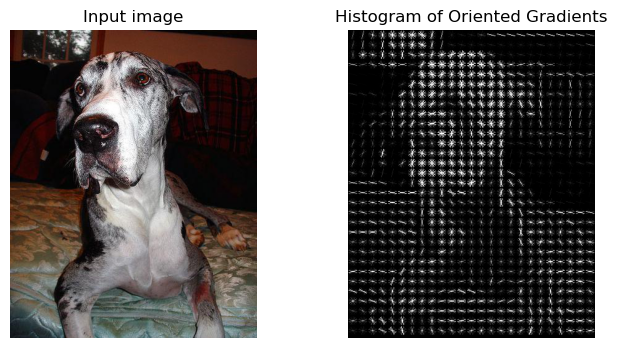

In [17]:
from skimage.feature import hog

image_path = images[1]
image = io.imread(image_path)
fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

(d) Dimensionalityreduction(usingPrincipalComponentAnalysis,PCA)
i. Use images from all four classes.
 ii. Convert all the images from the four classes to edge histograms.(0.5 points)
 iii. Perform Principal Component Analysis (PCA) dimensionality reduction on the set of his
tograms to reduce from 36 to 2 dimensions. (Note: You should not use the class labels) (1
 point)
 iv. Plot the 2D points using four different colors for data from the four classes (see Figure 1).
 Howmany classes are visually separable (i.e., non-overlapping) ? (1 point)

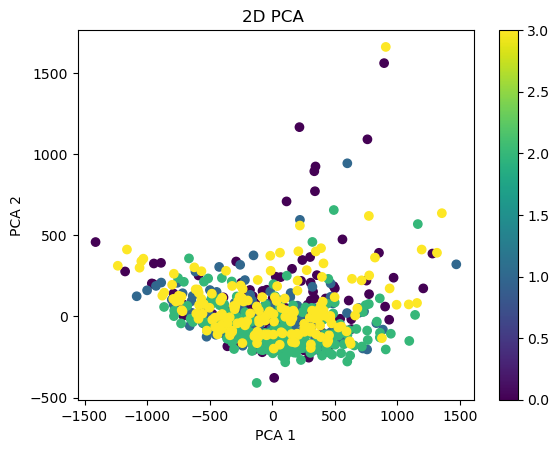

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

edge_histogram = []
classes = []

for index,name in enumerate(os.listdir(os.path.join(dir,images_folder))):
    path_folder = os.path.join('Cropped_Images',name)
    for file_path in os.listdir(path_folder):
        if file_path.endswith('.jpg') or file_path.endswith('.png'):  
            image_path = os.path.join(path_folder, file_path)
            gray_img = convert_gray(image_path)
            angle_sobel = angle(filters.sobel_h(gray_img), filters.sobel_v(gray_img))
            hist,hist_centers =exposure.histogram(angle_sobel,nbins=36)
            edge_histogram.append(hist)
            classes.append(index) 

edge_histogram = np.array(edge_histogram)
classes = np.array(classes)

pca = PCA(n_components=2)
h_pca = pca.fit_transform(edge_histogram)
names=os.listdir(os.path.join(dir,images_folder))
plt.scatter(h_pca[:, 0], h_pca[:, 1], c=classes)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA ')
plt.colorbar()
plt.show()

### we can see all the classes overlapping and could not be separable visually

3. Tweet Dataset is downloaded

In [22]:
## load the tweet data from json to data frame
import json
import pandas as pd
tweets=[]
with open('train.json', 'r') as file:
    for tweet in file:
        tweets.append(json.loads(tweet))
tweet_df = pd.DataFrame(tweets)

print(tweet_df.head())

              ID                                              Tweet  anger  \
0  2017-En-21153  Losing to Villa...'@M0tivati0nQuote: Most of t...  False   
1  2017-En-10384  @SiobhanSynnot  Oh, good God. Quentin Letts is...   True   
2  2017-En-31508  Pre-game nerves have settled in 😱 i'l be #chee...  False   
3  2017-En-11447         A persons opinion doesn't offend me at all  False   
4  2017-En-40669  @BillSwindell @DePauwU @dick_nixon I was havin...   True   

   anticipation  disgust   fear    joy   love  optimism  pessimism  sadness  \
0          True    False  False  False  False      True      False    False   
1         False     True  False  False  False     False      False    False   
2         False    False  False   True   True      True      False    False   
3         False    False  False  False  False      True      False    False   
4         False     True  False  False  False     False      False    False   

   surprise  trust  
0     False  False  
1     False  F

In [23]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    print(f"Value counts for {emotion}:")
    print(tweet_df[emotion].value_counts())
    print("\n")

Value counts for anger:
anger
False    1877
True     1123
Name: count, dtype: int64


Value counts for anticipation:
anticipation
False    2573
True      427
Name: count, dtype: int64


Value counts for disgust:
disgust
False    1850
True     1150
Name: count, dtype: int64


Value counts for fear:
fear
False    2448
True      552
Name: count, dtype: int64


Value counts for joy:
joy
False    1928
True     1072
Name: count, dtype: int64


Value counts for love:
love
False    2709
True      291
Name: count, dtype: int64


Value counts for optimism:
optimism
False    2138
True      862
Name: count, dtype: int64


Value counts for pessimism:
pessimism
False    2653
True      347
Name: count, dtype: int64


Value counts for sadness:
sadness
False    2103
True      897
Name: count, dtype: int64


Value counts for surprise:
surprise
False    2831
True      169
Name: count, dtype: int64


Value counts for trust:
trust
False    2845
True      155
Name: count, dtype: int64




 4. You will use the simple countvectorizer and tfidfvectorizer in https://scikit-learn.org/
 stable/api/sklearn.feature_extraction.html#module-sklearn.feature_extraction.text
 to extract (1) token (feature) counts, and (2) TF-IDF feature (counts), respectively. (You will use the
 default parameters.) What are the dimensionality of the two vector representations?

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Tweet = tweet_df['Tweet'].astype(str)
ct=CountVectorizer()
tfidf= TfidfVectorizer()
count_vector = ct.fit_transform(Tweet)
tfidf_vector = tfidf.fit_transform(Tweet)

print("CountVectorizer dimensionality:", count_vector.shape)
print("TfidfVectorizer dimensionality:", tfidf_vector.shape)

CountVectorizer dimensionality: (3000, 9519)
TfidfVectorizer dimensionality: (3000, 9519)


In [26]:
#eliminating stop words
Tweet = tweet_df['Tweet'].astype(str)
ct=CountVectorizer(stop_words='english')
tfidf= TfidfVectorizer(stop_words='english')
count_vector = ct.fit_transform(Tweet)
tfidf_vector = tfidf.fit_transform(Tweet)

print("CountVectorizer dimensionality:", count_vector.shape)
print("TfidfVectorizer dimensionality:", tfidf_vector.shape)

CountVectorizer dimensionality: (3000, 9259)
TfidfVectorizer dimensionality: (3000, 9259)


In [27]:
count_df = pd.DataFrame(count_vector.toarray(), columns=ct.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf.get_feature_names_out())

In [29]:
import pandas as pd

def get_top10_tokens(class_name):
    print(f"Top tokens for class: {class_name}")
    class_tweets = tweet_df[tweet_df[class_name] == True]
    class_counts = count_df.loc[class_tweets.index].sum().sort_values(ascending=False).head(10)
    tfidf_counts = tfidf_df.loc[class_tweets.index].sum().sort_values(ascending=False).head(10)
    print(f"Top tokens (CountVectorizer) for {class_name}:")
    print(class_counts)
    print(f"Top tokens (TF-IDF) for {class_name}:")
    print(tfidf_counts)
    print("\n")
emotion_classes = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
for class_name in emotion_classes:
    get_top10_tokens(class_name)

Top tokens for class: anger
Top tokens (CountVectorizer) for anger:
just       93
don        80
like       71
people     68
amp        56
anger      40
know       39
angry      39
fucking    35
going      34
dtype: int64
Top tokens (TF-IDF) for anger:
people      16.091596
just        15.930091
don         14.753484
like        13.133928
angry       11.179142
anger        9.991951
fuming       9.954694
rage         9.689209
fucking      9.543338
irritate     9.048149
dtype: float64


Top tokens for class: anticipation
Top tokens (CountVectorizer) for anticipation:
just     32
don      26
amp      25
know     20
start    20
want     18
think    18
watch    16
like     16
ll       15
dtype: int64
Top tokens (TF-IDF) for anticipation:
just     6.182867
start    5.779034
don      5.568025
want     4.727973
think    4.556148
watch    4.374331
know     4.304209
amp      4.272493
ll       3.886923
day      3.114938
dtype: float64


Top tokens for class: disgust
Top tokens (CountVectorizer) fo

### Anger,fear,love,surprise has different tokens which can be distinguished 

#### eliminating stop words


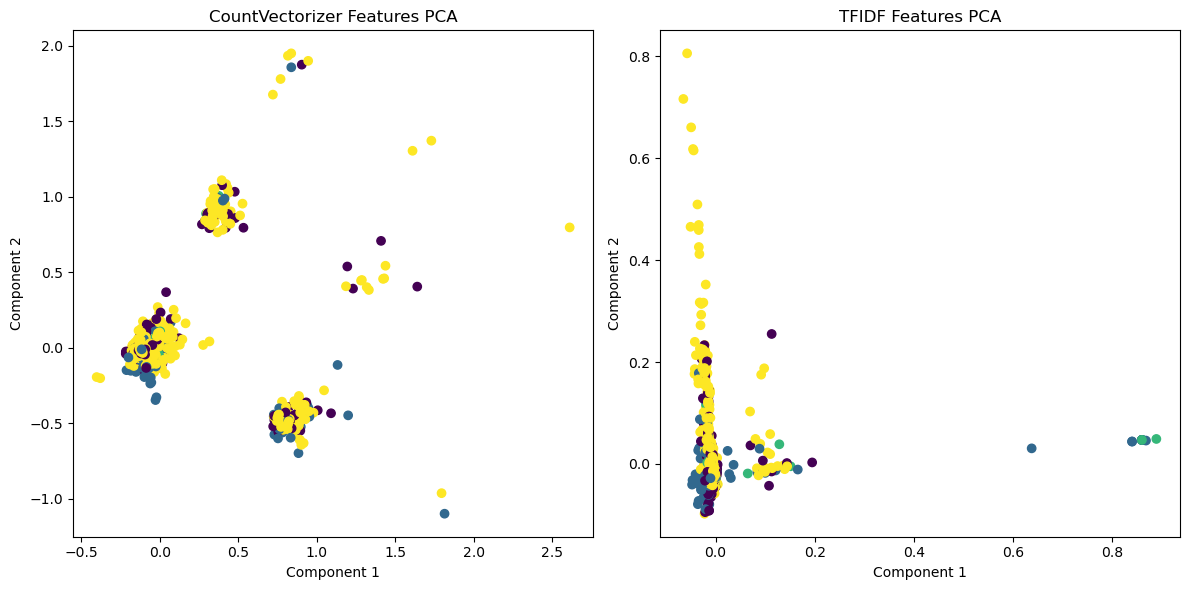

In [39]:
## eliminating stop words

selected = ['anger','fear', 'love', 'surprise',]
df_filter = tweet_df[tweet_df[selected].any(axis=1)]

count = CountVectorizer(stop_words='english').fit_transform(df_filter['Tweet'])
tfidf2 = TfidfVectorizer(stop_words='english').fit_transform(df_filter['Tweet'])

# Dimensionality Reduction
pca_count = PCA(n_components=2).fit_transform(count.toarray())
pca_tfidf = PCA(n_components=2).fit_transform(tfidf2.toarray())

class_colors = {'fear': 0, 'love': 1, 'surprise': 2, 'anger': 3}
df_filter['class'] = df_filter[selected].idxmax(axis=1) 
df_filter['color'] = df_filter['class'].map(class_colors)
# Plot CountVectorizer
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_count[:, 0], pca_count[:, 1], c=df_filter['color'])
plt.title('CountVectorizer Features PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')


# Plot TfidfVectorizer
plt.subplot(1, 2, 2)
plt.scatter(pca_tfidf[:, 0], pca_tfidf[:, 1], c=df_filter['color'])
plt.title('TFIDF Features PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

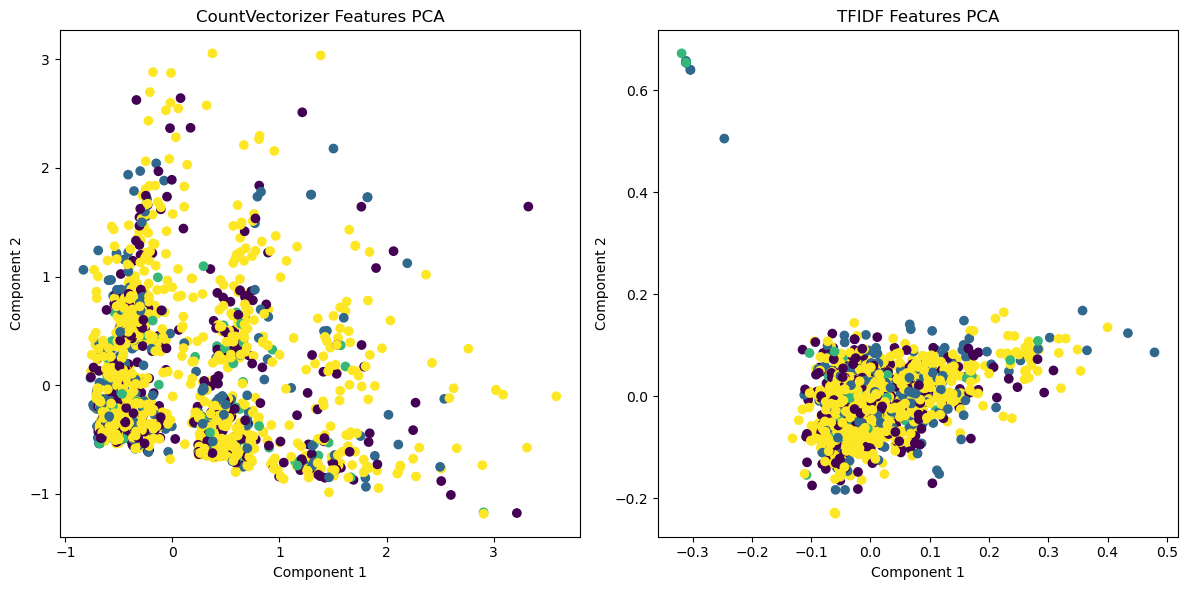

In [37]:

selected = ['anger','fear', 'love', 'surprise']
df_filter = tweet_df[tweet_df[selected].any(axis=1)]

count = CountVectorizer().fit_transform(df_filter['Tweet'])
tfidf2 = TfidfVectorizer().fit_transform(df_filter['Tweet'])

# Dimensionality Reduction
pca_count = PCA(n_components=2).fit_transform(count.toarray())
pca_tfidf = PCA(n_components=2).fit_transform(tfidf2.toarray())

class_colors = {'fear': 0, 'love': 1, 'surprise': 2, 'anger': 3}
df_filter['class'] = df_filter[selected].idxmax(axis=1) 
df_filter['color'] = df_filter['class'].map(class_colors)
# Plot CountVectorizer
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_count[:, 0], pca_count[:, 1], c=df_filter['color'])
plt.title('CountVectorizer Features PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')


# Plot TfidfVectorizer
plt.subplot(1, 2, 2)
plt.scatter(pca_tfidf[:, 0], pca_tfidf[:, 1], c=df_filter['color'])
plt.title('TFIDF Features PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

## in both cases emotionss are not separable visually 